In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import uuid

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
# from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc
from qiskit_ionq import IonQProvider

In [3]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

def state_init_bell_pairs_explicitCNOT(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=1/4))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
    qc.Add_Gate(Quantum_Gate("AZ",0,angle=(-1/20)))
        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            pass
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
    if (clifford=="XX"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("FTXA",2*i,2*i+1,angle=1/4))
            
def bell_measurement(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
        
def bell_measurement_explicitCNOT(qc,n):
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=1/4))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

def add_XX_clifford(circ,index):
    circ.z(2*index)
    circ.h(2*index)
    circ.x(2*index)
    circ.z(2*index)
    circ.cx(2*index,2*index+1)
    circ.s(2*index)
    circ.h(2*index)
    circ.x(2*index)
    circ.h(2*index+1)
    circ.s(2*index+1)
    circ.h(2*index+1)
        
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    
    

In [9]:
#define error model parameters

import math
from math import pi
from qiskit.quantum_info import Statevector
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

os.environ["IONQ_API_KEY"] = "2IrrtuzJntPCcKvJzkKczpA1TJKTH9LO"
my_api_key = os.getenv("IONQ_API_KEY")
# print (my_api_key)
provider = IonQProvider(my_api_key)

backend = provider.get_backend("ionq_simulator")
# backend = AerSimulator()


In [10]:
nqubit=2
S=Quantum_Circuit(2*nqubit,"qc")
total_depth=5
depth=[2**x for x in range(1,total_depth+1)] #depth for Concatenation
C=20#number of samples per depth

all_circuits=[]#a list of lists. circuits for all depths. each element is a list of circuit of a certain depth d.
all_circuits_explicit=[]
circuits=[] #a list of circuits with a certain depth d
circuits_explicit=[]
eab_data=[] #a list of dictionaries. Each dictionary is the results and relevant info of one circuit
results={}

clifford_layer="XX"
# t_echo=0

for d in depth:
    print ("\nDepth = %d"%d)
    print ("Number of samples = %d"%C)
    for i in range (C):

        #qiskit_circ=QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_state = QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_gates = QuantumCircuit(nqubit)

    
        #qiskit circuit state prep
        for j in range(nqubit):
            prepare_bell_state_1q(qiskit_c_state,j,j+nqubit)
        qiskit_c_state.barrier()

        
        for j in range(d):
            #gates circuit add pauli layer
            layer=add_pauli_twirl(S,nqubit)
            
            
            #qiskit circuit add pauli layer
            for q in range(nqubit):
                pauli_gate_1q(qiskit_c_gates,q,pauli=layer[q])
          
            #qiskit circuit add clifford layer
            if clifford_layer == 'Id':
                pass
            elif clifford_layer == 'CNOT':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    qiskit_c_gates.cx(2*q,2*q+1)
            elif clifford_layer == 'XX':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    add_XX_clifford(qiskit_c_gates,q)
            qiskit_c_gates.barrier()
            
        #gates circuit add Pauli twirl
        layer=add_pauli_twirl(S,nqubit)
      
        #qiskit circuit add Pauli twirl
        for j in range(nqubit):
            pauli_gate_1q(qiskit_c_gates,j,pauli=layer[j])
            #save the stablizer representation
        cliffordOp = Clifford(qiskit_c_gates)

        
        #for qiskit: append gates to state
        qiskit_circ = qiskit_c_state.compose(qiskit_c_gates,range(nqubit))

        
        #qiskit circuti bell measurement
        for j in range(nqubit):
            bell_measurement_1q(qiskit_circ,j,j+nqubit)
        qiskit_circ.barrier(range(2*nqubit))
        qiskit_circ.measure(range(2*nqubit),range(2*nqubit))
        
        # qiskit_circ.draw('mpl')

#         #for qiskit 
        qc_compiled = transpile(qiskit_circ, backend)
        job_sim = backend.run(qc_compiled, shots=2000,noise_model="harmony")
        # job_sim = backend.run(qc_compiled, shots=2000)
        result_sim = job_sim.result()
        counts_qiskit = result_sim.get_counts(qc_compiled)
                  
#         #package and format results
        results["n"]=nqubit
        results["L"]=d
        results["clifford"] = cliffordOp.to_dict()
        results["clifford_layer"] = clifford_layer

        # counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
        results["counts"]=counts_qiskit
        eab_data.append(results)

        results={}
    


Depth = 2
Number of samples = 20


NameError: name 'counts' is not defined

In [ ]:
# qiskit_circ.draw('mpl')

In [ ]:
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects/EAB")
import EAB_process_modified 
import itertools
'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_data, pauli_request_list)

print (eab_result)

{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.869, 0.834, 0.969, 0.761, 0.801, 0.837, 0.775, 1.0, 0.788, 0.799, 0.787, 0.767, 0.77, 0.829, 0.823, 0.806, 0.832, 0.821, 0.797, 0.84], 4: [0.785, 0.781, 0.785, 0.738, 0.751, 0.818, 0.791, 0.805, 0.785, 0.783, 0.755, 0.788, 0.769, 0.801, 0.768, 0.768, 0.775, 0.784, 1.0, 0.839], 8: [0.702, 0.736, 0.79, 0.736, 0.8, 0.672, 0.771, 0.751, 0.721, 0.799, 0.777, 0.759, 0.741, 0.755, 0.735, 0.691, 0.759, 0.8, 0.744, 0.739], 16: [0.588, 0.6

In [ ]:
raw_fidelity_list = eab_result["fidelity_list"]


# sys.exit(0)

fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)
print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))


Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.030306012474904387
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.01520712574404326 0.0008725489285771466
YI 0.04253628548295563 0.0020125202212778596
ZI 0.043815974913040345 0.0021129139061935843
IX 0.01826409211229285 0.0013224377954241975
XX 0.032095930633675995 0.0019627001462991585
YX 0.04367045027513605 0.002288764170551033
ZX 0.04633539068272308 0.0022510311720526067
IY 0.042356082819904994 0.0020603406256261237
XY 0.044584596481167416 0.002120171400225569
YY 0.0021497480702178384 0.0008184244609610415
ZY 0.016827454167436806 0.001186126305458952
IZ 0.04443746232684331 0.0023021282860645645
XZ 0.0456763994130136 0.002243914524040988
YZ 0.01624661581417297 0.0010809268375609796
ZZ 0.030692590661846375 0.0018169639616344917


Label / Pauli error rates
II 0.9696939875250955
XI -2.169871646329896e-05
YI 0.004098420362213938
ZI -3.5118485606562555e-05
IX 6.535624442102067e-05
XX 0.013870567824443632
YX 2.4528900673316534e-05
ZX 0.003171910289075909
IY 0.004371354015058608
XY 0.00041940591503012575
YY 7.570900436222605e-05
ZY 0.00021989897035681188
IZ 0.0004794556804149433
XZ 0.0035180086399776364
YZ -7.695447371748598e-05
ZZ 0.00012516830466349077


<BarContainer object of 15 artists>

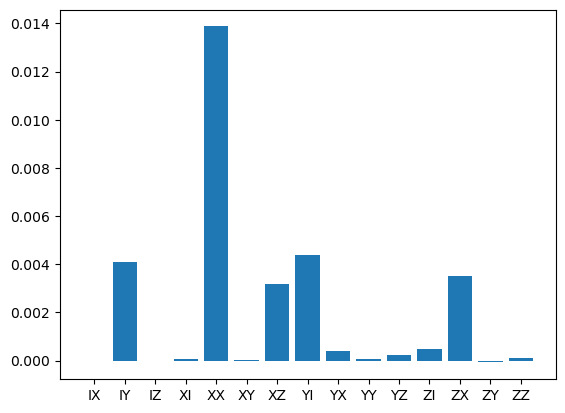

In [ ]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

plt.bar([label for label in error_list.keys()][1:],[error_list[label] for label in error_list.keys()][1:])

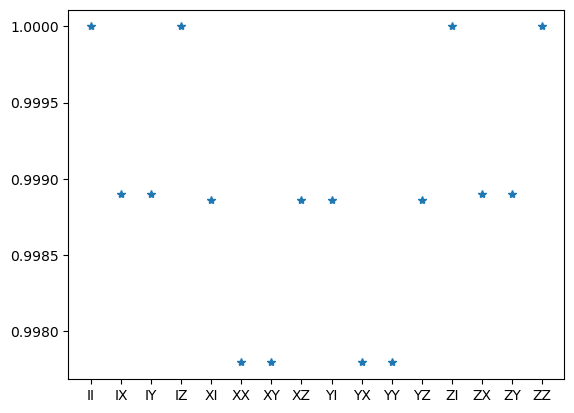

In [14]:
plt.plot([pauli_label for pauli_label in pauli_request_list],[fidelity_list[pauli_label] for pauli_label in pauli_request_list],"*")